In [38]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from feature_engine.selection import SmartCorrelatedSelection

import joblib

from pytorch_tabnet.tab_model import TabNetRegressor

# Load Files

In [34]:
df = pd.read_csv("data/CombinedData/cleaned_data_with_physical_model.csv")

# Plots

In [5]:
def plot_residuals(y_true, y_pred, title='Residual Plot', xlabel='Predicted Values', ylabel='Residuals'):
    # Calculate residuals
    residuals = y_true - y_pred

    # Plot residuals
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [6]:
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs. Predicted', xlabel='Actual Values', ylabel='Predicted Values'):
    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, color='blue', alpha=0.6, label='Predictions')

    # Perfect fit line (y = x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Fit (y = x)')

    # Trend Line (Linear Regression)
    model = LinearRegression()
    y_true_reshaped = np.array(y_true).reshape(-1, 1)  # Reshape y_true for fitting
    model.fit(y_true_reshaped, y_pred)
    trend_line = model.predict(y_true_reshaped)

    # Plot the trend line (green dashed line)
    plt.plot(y_true, trend_line, color='green', linestyle='-.', label='Trend Line (Linear Fit)')

    # Add labels, title, and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
def model_metrics(y_true, y_pred):
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error: {mse}')

    # Root Mean Squared Error
    rmse = mse ** 0.5
    print(f'Root Mean Squared Error: {rmse}')

    # R2 Score
    r2 = r2_score(y_true, y_pred)
    print(f'R2 Score: {r2}')

# Preprocess Data

In [8]:
def apply_pca(df, numerical_columns, n_components=2):
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(df[numerical_columns])

    # Create DataFrame with PCA components
    pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i+1}' for i in range(n_components)])

    # Concatenate PCA components with the original DataFrame

    return pca_df, pca

In [9]:
def select_k_best_features(df, target_col, k=10):
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Apply SelectKBest
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Top {k} selected features: {selected_features}")

    # Create a new DataFrame with selected features
    selected_df = df[[target_col] + selected_features]

    return selected_df

In [10]:
def smart_correlated_selection(X, y):
    # Smart Correlated Selection
    tr = SmartCorrelatedSelection(
        variables=None,
        method="pearson",
        threshold=0.8,
        missing_values="raise",
        selection_method="model_performance",
        estimator=XGBRegressor(random_state=1, n_jobs=-1),
        scoring='neg_mean_squared_error',
        cv=2,
    )

    Xt = tr.fit_transform(X, y)
    features_to_drop = tr.features_to_drop_
    selected_features = Xt.columns
    
    print(f"Correlated features sets: {tr.correlated_feature_sets_}")
    print(f"Correlated features dict: {tr.correlated_feature_dict_}")
    print(f"Features to drop: {features_to_drop}")
    print(f"Selected features: {selected_features}")

    return Xt, features_to_drop, selected_features

# Reduce Multicollinearity

In [11]:
X = df.drop(columns=['produced energy', "relative_output"])
y = df['relative_output']
Xt, features_to_drop, selected_features = smart_correlated_selection(X, y)

Correlated features sets: [{'cell_temp', 'temperature_2m'}, {'direct_normal_irradiance', 'clearsky_index'}, {'cloud_cover_3_moving_average', 'cloud_cover', 'cloud_cover_hour_minus_1'}, {'day_of_year_cos', 'month_cos'}, {'month_sin', 'day_of_year_sin'}, {'shortwave_radiation', 'poa_hour_minus_1', 'direct_radiation', 'diffuse_radiation', 'solar_elevation', 'is_day', 'solar_zenith', 'hour_cos', 'poa', 'physical_model_prediction'}, {'surface_pressure', 'pressure_msl'}]
Correlated features dict: {'cell_temp': {'temperature_2m'}, 'direct_normal_irradiance': {'clearsky_index'}, 'cloud_cover_3_moving_average': {'cloud_cover', 'cloud_cover_hour_minus_1'}, 'month_cos': {'day_of_year_cos'}, 'day_of_year_sin': {'month_sin'}, 'poa': {'shortwave_radiation', 'poa_hour_minus_1', 'direct_radiation', 'diffuse_radiation', 'solar_elevation', 'is_day', 'solar_zenith', 'hour_cos', 'physical_model_prediction'}, 'pressure_msl': {'surface_pressure'}}
Features to drop: ['temperature_2m', 'clearsky_index', 'clou

In [12]:
Xt

,kwp,relative_humidity_2m,dew_point_2m,pressure_msl,precipitation,wind_speed_10m,wind_direction_10m,direct_normal_irradiance,day_of_year,solar_azimuth,poa,cloud_cover_3_moving_average,cell_temp,hour_sin,day_of_year_sin,month_cos,relative_physical_model_prediction
0,3.850148,0.645752,-0.271319,1.485072,9.999995e-07,-0.894182,-1.757843,9.999995e-07,-1.699010,-1.224292,9.999995e-07,-1.710732,-0.618186,0.500,0.017,0.866,0.0
1,3.850148,0.645752,-0.310398,1.503887,9.999995e-07,-0.808787,-1.727175,9.999995e-07,-1.699010,-1.039012,9.999995e-07,-1.710732,-0.655825,0.707,0.017,0.866,0.0
2,3.850148,0.645752,-0.349477,1.466257,9.999995e-07,-0.662397,-1.706730,9.999995e-07,-1.699010,-0.921640,9.999995e-07,-1.710732,-0.680918,0.866,0.017,0.866,0.0
3,3.850148,0.719137,-0.388556,1.447441,9.999995e-07,-0.637998,-1.655618,9.999995e-07,-1.699010,-0.830393,9.999995e-07,-1.710732,-0.718556,0.966,0.017,0.866,0.0
4,3.850148,0.719137,-0.427636,1.447441,9.999995e-07,-0.540405,-1.645395,9.999995e-07,-1.699010,-0.748655,9.999995e-07,-1.710732,-0.756195,1.000,0.017,0.866,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846958,1.504077,0.645752,0.412568,-1.158491,9.999995e-07,0.045157,0.204875,9.999995e-07,0.809968,0.953726,9.999995e-07,0.210826,-0.204160,-0.966,-1.000,-0.000,0.0
846959,1.504077,0.719137,0.353949,-1.205529,9.999995e-07,-0.247624,0.143540,9.999995e-07,0.809968,1.079166,9.999995e-07,0.083506,-0.254345,-0.866,-1.000,-0.000,0.0
846960,1.504077,0.792522,0.334409,-1.233752,9.531018e-02,-0.430612,0.041315,9.999995e-07,0.809968,1.215173,9.999995e-07,0.475030,-0.279438,-0.707,-1.000,-0.000,0.0
846961,1.504077,0.865906,0.393028,-1.318421,9.555114e-01,-0.979576,-0.009797,9.999995e-07,0.809968,1.366066,9.999995e-07,0.893877,-0.266891,-0.500,-1.000,-0.000,0.0


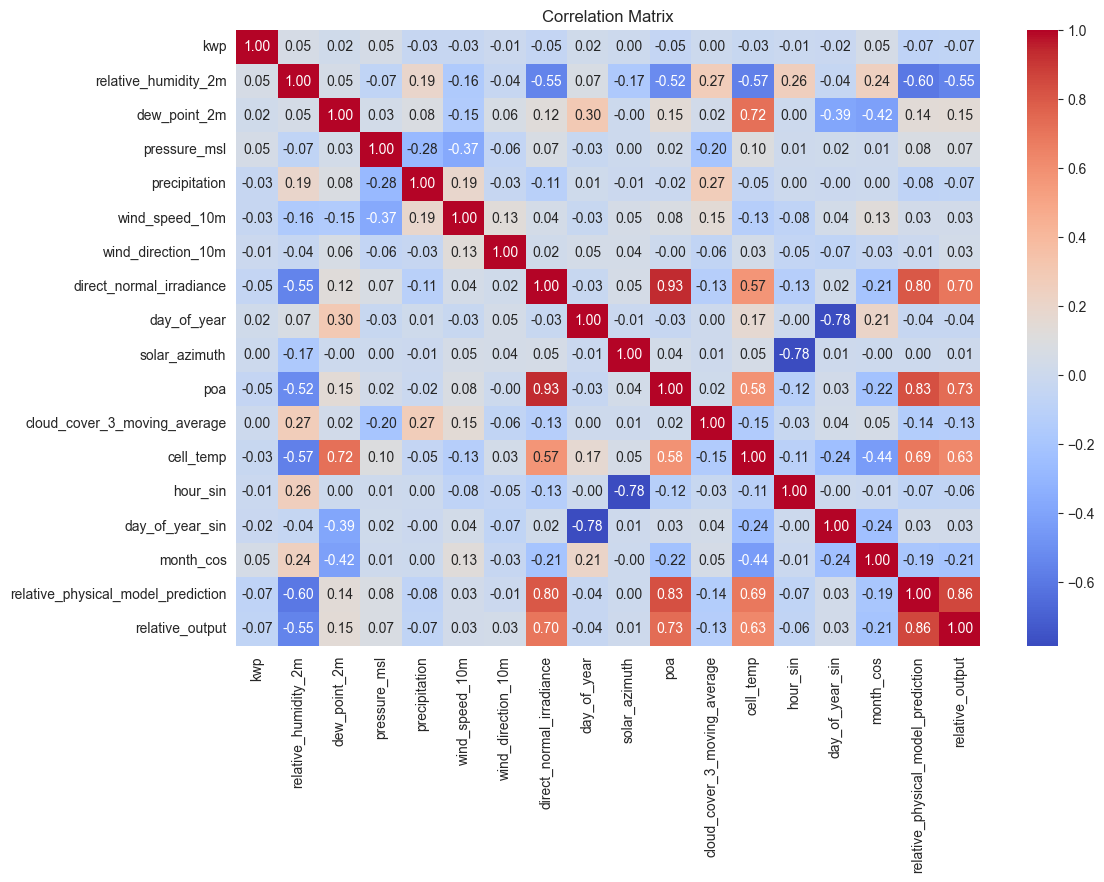

In [186]:
# correlation matrix
corr = Xt.copy()
corr['relative_output'] = y
corr = corr.corr()

# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# ML Models


## XGBoost

### Split Data

In [13]:
X = df[selected_features]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning

### Train Model

In [14]:
# Define the XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define parameter distributions for Randomized Search
param_distributions = {
    'n_estimators': np.arange(100, 1000, 50),         # Increase trees to learn more
    'max_depth': np.arange(6, 15, 1),               # Allow deeper trees to capture complex patterns
    'learning_rate': np.linspace(0.01, 0.2, 10),    # Test smaller learning rates for finer updates
    'subsample': np.linspace(0.7, 1.0, 5),          # Slightly lower subsampling to avoid overfitting
    'colsample_bytree': np.linspace(0.7, 1.0, 5),   # Reduce columns per tree
    'gamma': np.linspace(0, 1, 5),                  # Allow splits with smaller gains
    'min_child_weight': np.arange(1, 10, 1),        # Test smaller values to better fit high kWp
    'reg_alpha': np.linspace(0, 1, 5),              # L1 regularization (smaller values to reduce restrictions)
    'reg_lambda': np.linspace(0.5, 2, 5),           # L2 regularization (for generalization)
}

# RandomizedSearchCV configuration
random_search_xg = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Use MSE as scoring metric
    cv=2,  # 3-fold cross-validation
    verbose=2,  # Show progress
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Run the random search
random_search_xg.fit(X_train, y_train)


# Evaluate the best model on the test set
best_model_xg = random_search_xg.best_estimator_
y_pred_xg = best_model_xg.predict(X_test)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END colsample_bytree=0.7749999999999999, gamma=0.5, learning_rate=0.07333333333333333, max_depth=6, min_child_weight=5, n_estimators=800, reg_alpha=0.75, reg_lambda=1.625, subsample=0.85; total time=   9.3s
[CV] END colsample_bytree=0.85, gamma=0.25, learning_rate=0.1366666666666667, max_depth=11, min_child_weight=4, n_estimators=350, reg_alpha=0.5, reg_lambda=1.25, subsample=0.85; total time=   6.9s
[CV] END colsample_bytree=0.85, gamma=0.25, learning_rate=0.1366666666666667, max_depth=13, min_child_weight=9, n_estimators=150, reg_alpha=0.0, reg_lambda=1.25, subsample=0.7; total time=   7.1s
[CV] END colsample_bytree=0.7, gamma=0.5, learning_rate=0.1577777777777778, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.875, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.7749999999999999, gamma=0.5, learning_rate=0.1366666666666667, max_depth=11, min_child_weight=1, n_estimators=5

In [15]:
# Best parameters and score
print("Best parameters:", random_search_xg.best_params_)
print("Best CV score (MSE):", -random_search_xg.best_score_)

Best parameters: {'subsample': 0.85, 'reg_lambda': 0.875, 'reg_alpha': 1.0, 'n_estimators': 800, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.03111111111111111, 'gamma': 0.0, 'colsample_bytree': 0.85}
Best CV score (MSE): 0.0033520755412500664


### Model Metrics

In [16]:
model_metrics(y_test, y_pred_xg)

Mean Absolute Error: 0.025332135490055533
Mean Squared Error: 0.003117961155100607
Root Mean Squared Error: 0.05583870660304201
R2 Score: 0.8978690294852688


### Plot Results

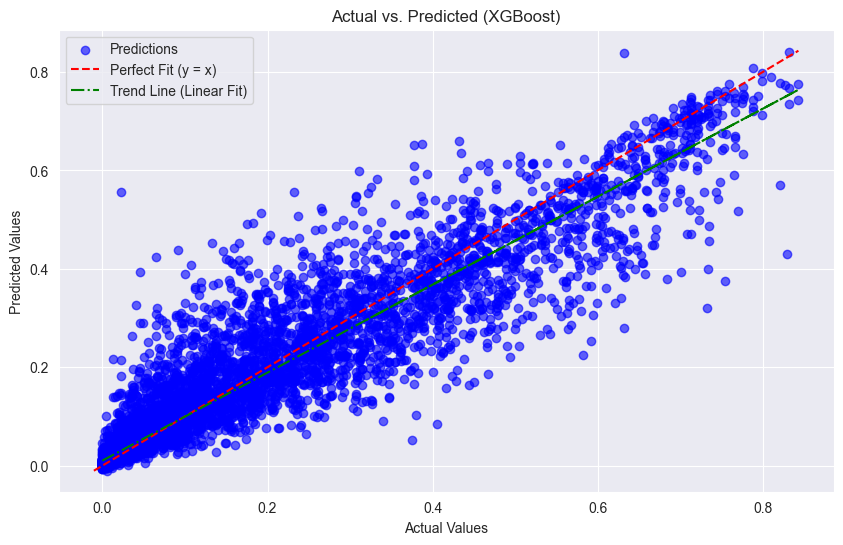

In [17]:
# Plot Actual vs Predicted
plot_actual_vs_predicted(y_test[:10000], y_pred_xg[:10000], title='Actual vs. Predicted (XGBoost)', xlabel='Actual Values', ylabel='Predicted Values')

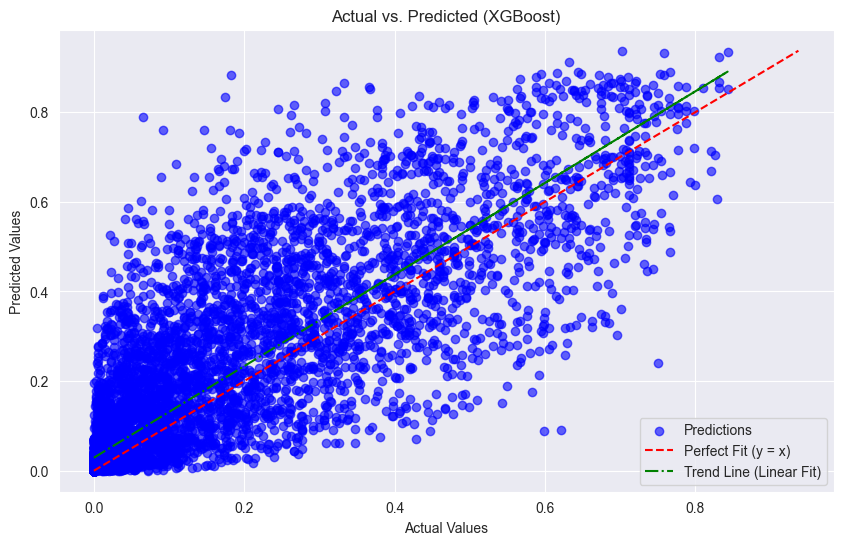

In [191]:
# Plot Actual vs Predicted
plot_actual_vs_predicted(y_test[:10000], X_test["relative_physical_model_prediction"][:10000], title='Actual vs. Predicted (XGBoost)', xlabel='Actual Values', ylabel='Predicted Values')

Feature Importances:
Feature: poa, Importance: 0.5780
Feature: relative_physical_model_prediction, Importance: 0.1750
Feature: hour_sin, Importance: 0.0573
Feature: direct_normal_irradiance, Importance: 0.0360
Feature: month_cos, Importance: 0.0319
Feature: kwp, Importance: 0.0311
Feature: cell_temp, Importance: 0.0236
Feature: solar_azimuth, Importance: 0.0195
Feature: precipitation, Importance: 0.0064
Feature: relative_humidity_2m, Importance: 0.0064
Feature: day_of_year, Importance: 0.0061
Feature: cloud_cover_3_moving_average, Importance: 0.0058
Feature: day_of_year_sin, Importance: 0.0055
Feature: wind_direction_10m, Importance: 0.0054
Feature: dew_point_2m, Importance: 0.0044
Feature: pressure_msl, Importance: 0.0039
Feature: wind_speed_10m, Importance: 0.0039


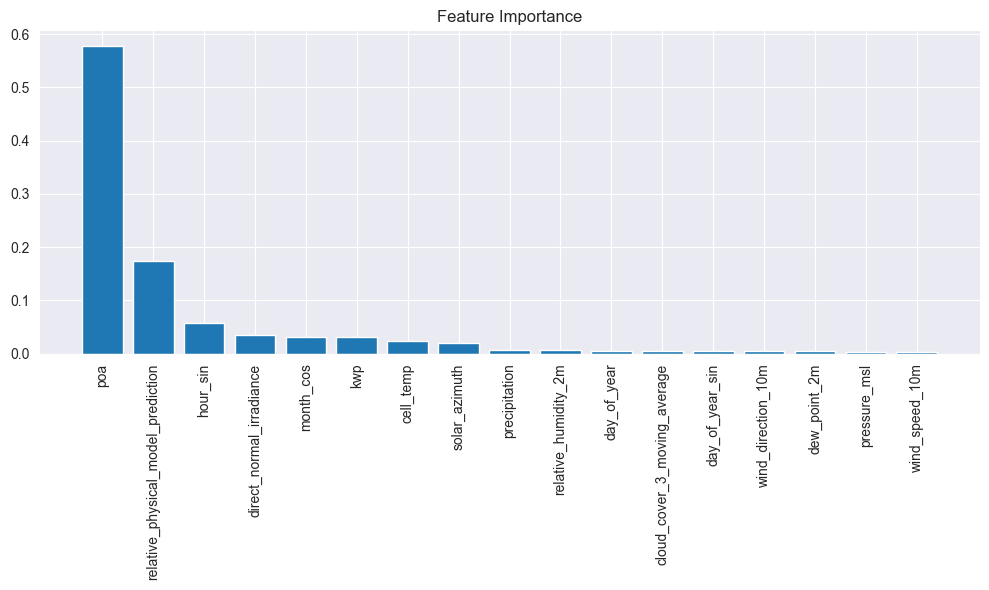

In [19]:
# Feature Importance
importances = best_model_xg.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

# Print feature importances
print("Feature Importances:")
for idx in indices:
    print(f"Feature: {features[idx]}, Importance: {importances[idx]:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


### Save Model

In [21]:
joblib.dump(best_model_xg, "models/xgboost_model.pkl")

['models/xgboost_model.pkl']

## Random Forest

### Split Data

In [26]:
X = df[selected_features]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [27]:
# Define and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

### Model Metrics

In [28]:
# Model Metrics
model_metrics(y_test, y_pred_rf)

Mean Absolute Error: 0.032400070452425364
Mean Squared Error: 0.004632168761688217
Root Mean Squared Error: 0.06806003792012033
R2 Score: 0.8482701138064779


### Plot Results

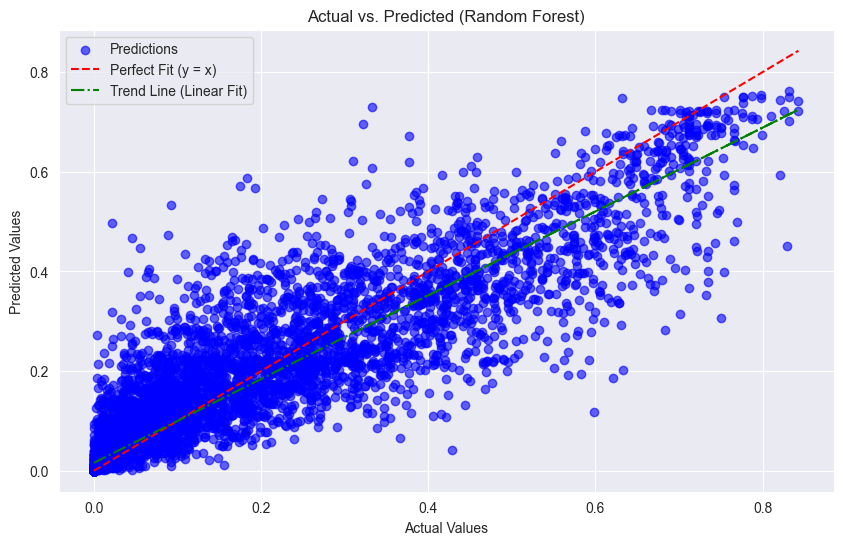

In [30]:
plot_actual_vs_predicted(y_test[:10000], y_pred_rf[:10000], title='Actual vs. Predicted (Random Forest)', xlabel='Actual Values', ylabel='Predicted Values')

### Save Model

In [39]:
joblib.dump(rf, "models/random_forest_model.pkl")

['models/random_forest_model.pkl']

## Tabnet

### Split Data

In [43]:
X = df[selected_features]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [44]:
X_train = X_train.values  # Convert to NumPy array
X_test = X_test.values  # Convert to NumPy array

y_train = y_train.values.reshape(-1, 1)  # Reshape to 2D for TabNet
y_test = y_test.values.reshape(-1, 1)  # Reshape to 2D for TabNet

# Define and train TabNet model
tabnet = TabNetRegressor(verbose=10)
tabnet.fit(
    X_train, y_train,  # Pass reshaped targets
    eval_set=[(X_test, y_test)],  # Pass reshaped test targets
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=256
)

# Make predictions
y_pred_tabnet = tabnet.predict(X_test)
y_pred_tabnet = np.maximum(y_pred_tabnet, 0)  # Ensure predictions are non-negative

/Users/entl/Library/Mobile Documents/com~apple~CloudDocs/University/Final Project/ML/.venv/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.00806 | val_0_rmse: 0.07655 |  0:00:19s


KeyboardInterrupt: 

### Model Metric

In [ ]:
# Model Metrics
model_metrics(y_test, y_pred_tabnet)

### Plot Results

In [ ]:
plot_actual_vs_predicted(y_test, y_pred_tabnet, title='Actual vs. Predicted (TabNet)', xlabel='Actual Values', ylabel='Predicted Values')

### Feature importance

In [ ]:
print("Feature Importance:", tabnet.feature_importances_)

## MLP

### Split Data


In [45]:
X = df[selected_features]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [46]:
# Define and train the MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # Three hidden layers
    activation='relu',                # Activation function
    solver='adam',                    # Optimizer
    alpha=0.0001,                     # L2 regularization
    batch_size=128,                   # Batch size
    max_iter=100,                     # Maximum iterations
    random_state=42,
    early_stopping=True,              # Enable early stopping
    verbose=True                      # Enable verbose output
)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

Iteration 1, loss = 0.00301755
Validation score: 0.838964
Iteration 2, loss = 0.00243618
Validation score: 0.844331
Iteration 3, loss = 0.00232656
Validation score: 0.848661
Iteration 4, loss = 0.00227108
Validation score: 0.856143
Iteration 5, loss = 0.00223927
Validation score: 0.856198
Iteration 6, loss = 0.00221593
Validation score: 0.856894
Iteration 7, loss = 0.00219531
Validation score: 0.859322
Iteration 8, loss = 0.00218407
Validation score: 0.859194
Iteration 9, loss = 0.00216989
Validation score: 0.855032
Iteration 10, loss = 0.00216394
Validation score: 0.861327
Iteration 11, loss = 0.00215207
Validation score: 0.860495
Iteration 12, loss = 0.00214733
Validation score: 0.861863
Iteration 13, loss = 0.00214258
Validation score: 0.852992
Iteration 14, loss = 0.00213119
Validation score: 0.863156
Iteration 15, loss = 0.00212400
Validation score: 0.859966
Iteration 16, loss = 0.00212430
Validation score: 0.860497
Iteration 17, loss = 0.00211609
Validation score: 0.865128
Iterat

### Model Metrics

In [47]:
y_pred_mlp = np.maximum(y_pred_mlp, 0)  # Ensure predictions are non-negative
model_metrics(y_test, y_pred_mlp)

Mean Absolute Error: 0.02968802282600609
Mean Squared Error: 0.0039984672501153585
Root Mean Squared Error: 0.06323343459053413
R2 Score: 0.8690274443741512


### Plot Results

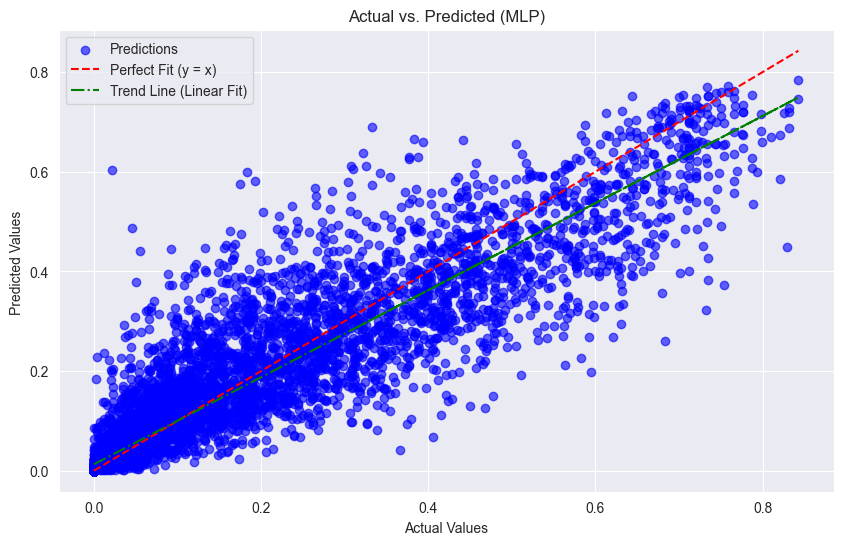

In [48]:
plot_actual_vs_predicted(y_test[:10000], y_pred_mlp[:10000], title='Actual vs. Predicted (MLP)', xlabel='Actual Values', ylabel='Predicted Values ')

### Save Model

In [49]:
joblib.dump(mlp, "models/mlp_model.pkl")

['models/mlp_model.pkl']

## SVR

### Split Data

In [ ]:
svr_df = df.copy()
svr_df = svr_df.resample(n=100000) # SVR is slow with large datasets

X = df['kwp', 'relative_humidity_2m', 'dew_point_2m', 'pressure_msl',
       'precipitation', 'wind_speed_10m', 'wind_direction_10m',
       'direct_normal_irradiance', 'sunshine_duration', 'solar_azimuth', 'poa',
       'cloud_cover_3_moving_average', 'day_of_year', 'cell_temp', 'hour_sin',
       'day_of_year_sin', 'month_cos']
y = df['produced energy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [ ]:
from sklearn.svm import SVR

# Define and train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

svr.fit(X_train, y_train)

# Predictions
y_pred_svr = svr.predict(X_test)

### Model Metrics

In [ ]:
# Model Metrics
model_metrics(y_test, y_pred_svr)

### Plot Results

In [ ]:
plot_actual_vs_predicted(y_test, y_pred_svr, title='Actual vs. Predicted (SVR)', xlabel='Actual Values', ylabel='Predicted Values')

## XGBoost + MLP + Ridge Stacking

### Split Data

In [ ]:
X = df[['kwp', 'relative_humidity_2m', 'dew_point_2m', 'pressure_msl',
       'precipitation', 'wind_speed_10m', 'wind_direction_10m',
       'direct_normal_irradiance', 'solar_azimuth', 'poa',
       'cloud_cover_3_moving_average', 'cell_temp', 'hour_sin',
       'day_of_year_sin', 'month_cos', "solar_elevation", "solar_zenith"]]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

In [ ]:
base_estimators = [
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64, 32), random_state=42, verbose=True))
]

meta_estimator = Ridge()

xgb_mlp_stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_estimator,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)  # or just cv=5
)

# Train the stack
xgb_mlp_stacking_regressor.fit(X_train, y_train)

# Evaluate on validation or test
xgb_mlp_y_predictions = xgb_mlp_stacking_regressor.predict(X_test)

### Model Metrics

In [ ]:
model_metrics(y_test, xgb_mlp_y_predictions)

### Plot Results

In [ ]:
plot_actual_vs_predicted(y_test, xgb_mlp_y_predictions, title='Actual vs. Predicted (XGBoost + MLP + Ridge Stacking)', xlabel='Actual Values', ylabel='Predicted Values')

# Hyperparameter Tuning

In [84]:
from sklearn.model_selection import RandomizedSearchCV

df["relative_physical_model_prediction"] = df["physical_model_prediction"] / df["kwp"]

X = df[['kwp', 'relative_humidity_2m', 'dew_point_2m', 'pressure_msl',
       'precipitation', 'wind_speed_10m', 'wind_direction_10m',
       'direct_normal_irradiance', 'solar_azimuth', 'poa',
       'cloud_cover_3_moving_average', 'cell_temp', 'hour_sin',
       'day_of_year_sin', 'month_cos', "solar_elevation", "solar_zenith", "relative_physical_model_prediction"]]
y = df['relative_output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END colsample_bytree=0.85, gamma=1.0, learning_rate=0.09444444444444444, max_depth=8, min_child_weight=8, n_estimators=750, reg_alpha=0.0, reg_lambda=2.0, subsample=0.925; total time=   3.2s
[CV] END colsample_bytree=0.925, gamma=0.5, learning_rate=0.07333333333333333, max_depth=11, min_child_weight=1, n_estimators=850, reg_alpha=1.0, reg_lambda=0.875, subsample=0.925; total time=   3.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.09444444444444444, max_depth=12, min_child_weight=7, n_estimators=200, reg_alpha=0.25, reg_lambda=0.875, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.7749999999999999, gamma=0.5, learning_rate=0.1366666666666667, max_depth=11, min_child_weight=1, n_estimators=500, reg_alpha=1.0, reg_lambda=1.625, subsample=0.85; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.25, learning_rate=0.1577777777777778, max_depth=7, min_child_weight=3, n_estimators=600, reg_al

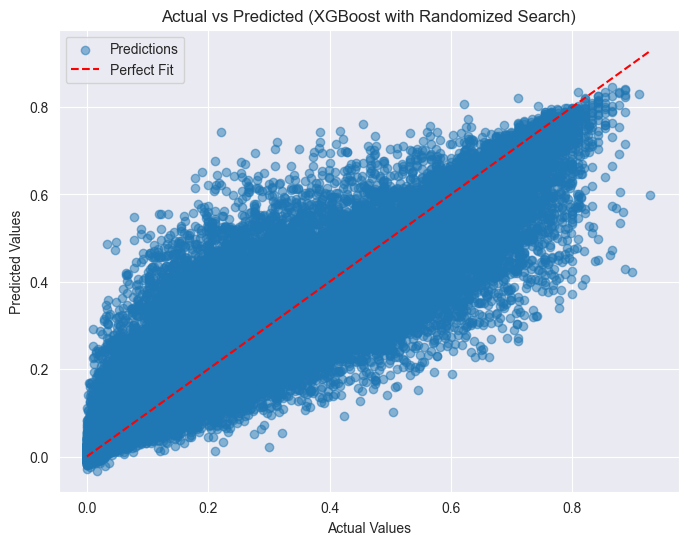

In [85]:

# Define the XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define parameter distributions for Randomized Search
param_distributions = {
    'n_estimators': np.arange(100, 1000, 50),         # Increase trees to learn more
    'max_depth': np.arange(6, 15, 1),               # Allow deeper trees to capture complex patterns
    'learning_rate': np.linspace(0.01, 0.2, 10),    # Test smaller learning rates for finer updates
    'subsample': np.linspace(0.7, 1.0, 5),          # Slightly lower subsampling to avoid overfitting
    'colsample_bytree': np.linspace(0.7, 1.0, 5),   # Reduce columns per tree
    'gamma': np.linspace(0, 1, 5),                  # Allow splits with smaller gains
    'min_child_weight': np.arange(1, 10, 1),        # Test smaller values to better fit high kWp
    'reg_alpha': np.linspace(0, 1, 5),              # L1 regularization (smaller values to reduce restrictions)
    'reg_lambda': np.linspace(0.5, 2, 5),           # L2 regularization (for generalization)
}

# RandomizedSearchCV configuration
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Use MSE as scoring metric
    cv=2,  # 3-fold cross-validation
    verbose=2,  # Show progress
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Run the random search
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best CV score (MSE):", -random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (XGBoost with Randomized Search)")
plt.legend()
plt.show()

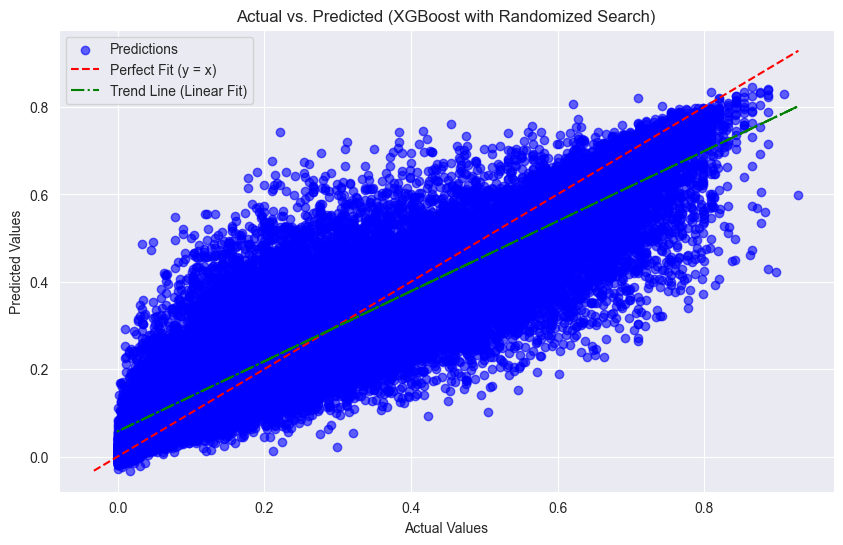

In [86]:
plot_actual_vs_predicted(y_test, y_pred, title='Actual vs. Predicted (XGBoost with Randomized Search)', xlabel='Actual Values', ylabel='Predicted Values')

In [87]:
y_pred = best_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)  # Ensure predictions are non-negative
model_metrics(y_test, y_pred)

Mean Absolute Error: 0.06358318659952328
Mean Squared Error: 0.00816993196720494
Root Mean Squared Error: 0.09038767596970806
R2 Score: 0.8103969412932654


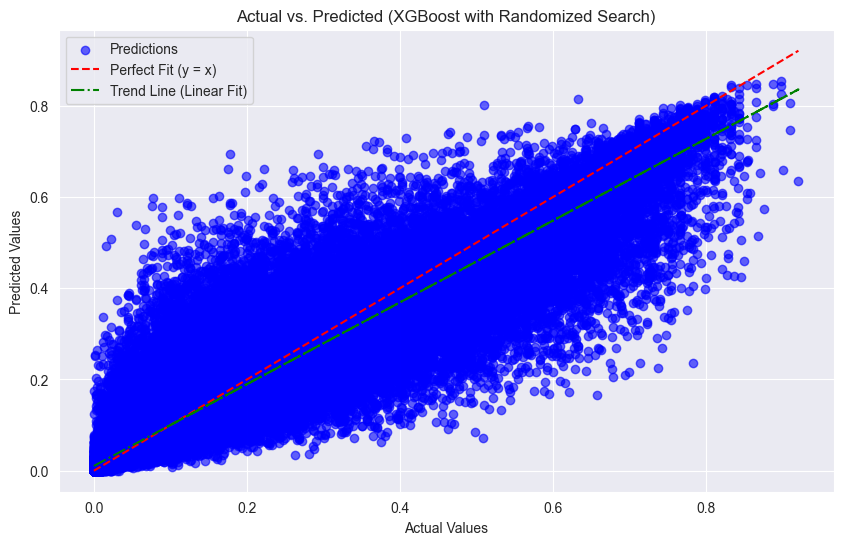

In [ ]:
plot_actual_vs_predicted(y_test, y_pred, title='Actual vs. Predicted (XGBoost with Randomized Search)', xlabel='Actual Values', ylabel='Predicted Values')